### Load a saved model and try predicting captions

In [1]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json, load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

Using TensorFlow backend.
/mnt/c/Users/Kanishk/Documents/Projects/sem6 miniproject/sem6/wsl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/c/Users/Kanishk/Documents/Projects/sem6 miniproject/sem6/wsl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/c/Users/Kanishk/Documents/Projects/sem6 miniproject/sem6/wsl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type

In [2]:
# standard variables
MAX_LENGTH = 52
VOCAB_SIZE = 6321 # Using unique words as vocab here.
NPIX = 299
TARGET_SIZE = (NPIX,NPIX,3)
EMBEDDING_SIZE = 300

In [3]:
def load_model_from_json(path):
    with open(path,"r") as f:
        model = model_from_json(f.read())
    print("Model loaded successfully")
    return model

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

index_and_words = load_pickle("index_and_words.pkl")
ix_to_word = index_and_words['ix_to_word']
word_to_ix = index_and_words['word_to_ix']

print(len(ix_to_word))
print(len(word_to_ix))

6320
6320


#### load pre-configured inception model
Used for generating feature matrix for images directly.

If images are preprocessed, simply load the pickle and feed the feature vector to the model as input.

This inception model has last softmax layer removed, and the remaining layers are frozen (`layer.trainable = False`)

In [4]:
modified_inception = load_model("modified_inception.h5", compile=False)

#### Load our CNN+RNN model along with trained weights

In [10]:
model = load_model_from_json("model.json")

# loading the weights of the model
model.load_weights("model_weights/amey_19.h5")

# model.save("coco_19th_epoch.h5")

Model loaded successfully


In [11]:
# model = load_model("model_weights/amey_19.h5", compile=False)

In [6]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(MAX_LENGTH):
        sequence = [word_to_ix[w] for w in in_text.split() if w in word_to_ix]
        sequence = pad_sequences([sequence], maxlen=MAX_LENGTH)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ix_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [7]:
def beam_search_predictions(photo, beam_index=3):
    start = [word_to_ix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < MAX_LENGTH:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=MAX_LENGTH, padding='post')
            preds = model.predict([photo, par_caps], verbose=0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ix_to_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [8]:
def getFeatureVector(imgPath):
    try:
        img = load_img(imgPath, target_size=TARGET_SIZE)
    except OSError as e:
        print("Problem with image:",e)
    
    # Converting image to array
    img_array = img_to_array(img)
    nimage = preprocess_input(img_array)
    # Adding one more dimesion
    nimage = np.expand_dims(nimage, axis=0)    
    fea_vec = modified_inception.predict(nimage)
    return np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )

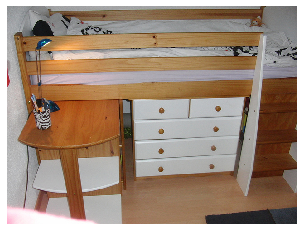

Greedy Search:  a wooden bunk bed with a wooden frame
Beam Search (k=3):  a bunk bed with a picture of a rhino on it
Beam Search (k=5):  a bunk bed in a room next to a lamp
Beam Search (k=7):  a bunk bed in a room next to a lamp


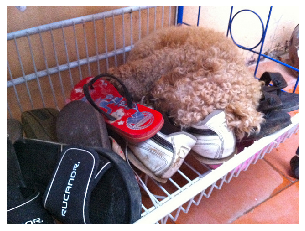

Greedy Search:  a dog sitting on a chair next to a stuffed animal
Beam Search (k=3):  a dog sitting on a chair next to a teddy bear
Beam Search (k=5):  a teddy bear sitting on top of a piece of wood
Beam Search (k=7):  a brown teddy bear sitting on top of a piece of wood


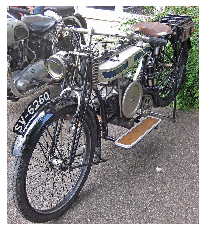

Greedy Search:  a bike parked next to a red door
Beam Search (k=3):  a motorcycle parked on the side of the road in front of a store
Beam Search (k=5):  a motorcycle parked on the side of the road next to a bike
Beam Search (k=7):  a group of motorcycles parked next to each other on a sidewalk


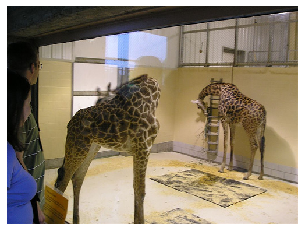

Greedy Search:  a giraffe standing in a field next to a building
Beam Search (k=3):  a giraffe standing next to another giraffe in a zoo
Beam Search (k=5):  a couple of giraffe standing next to each other on a field
Beam Search (k=7):  a couple of giraffe standing next to each other at a zoo


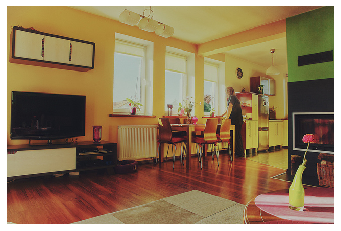

Greedy Search:  a living room with a couch and a tv
Beam Search (k=3):  a living room filled with furniture and a flat screen tv
Beam Search (k=5):  a living room filled with furniture and a flat screen tv
Beam Search (k=7):  a living room filled with furniture and a flat screen tv


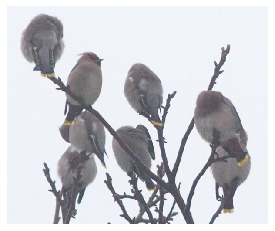

Greedy Search:  a bird sitting on a branch in the grass
Beam Search (k=3):  the bird is sitting on the edge of the tree
Beam Search (k=5):  a close up of a bird sitting on a branch
Beam Search (k=7):  a close up of a bird sitting on top of a rock


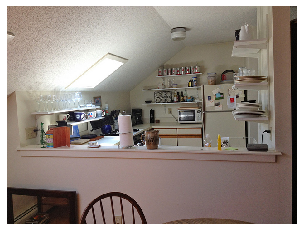

Greedy Search:  a kitchen with a stove and a sink
Beam Search (k=3):  a living room with a couch and a tv
Beam Search (k=5):  there is a kitchen with a sink and a refrigerator
Beam Search (k=7):  a living room filled with furniture and a flat screen tv


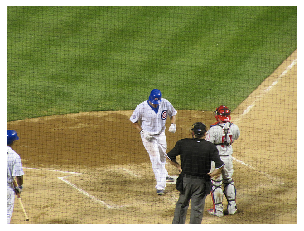

Greedy Search:  a baseball player holding a bat on a field
Beam Search (k=3):  a baseball player holding a bat while standing next to home plate
Beam Search (k=5):  a baseball player swinging a bat at a ball
Beam Search (k=7):  a baseball player holding a bat while standing next to home plate


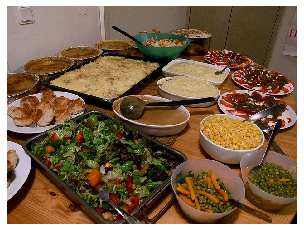

Greedy Search:  a table with a lot of food on it
Beam Search (k=3):  plates of food on a table with a lot of food
Beam Search (k=5):  a bunch of food that are sitting on a table
Beam Search (k=7):  a table topped with lots of different types of food


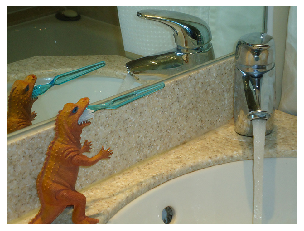

Greedy Search:  a bathroom with a sink and a mirror
Beam Search (k=3):  a close up of a urinal in a bathroom
Beam Search (k=5):  a close up of a urinal in a bathroom
Beam Search (k=7):  a close up of a urinal in a bathroom


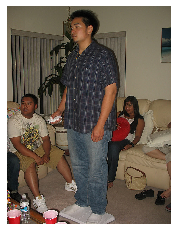

Greedy Search:  a group of people standing around a living room playing nintendo wii
Beam Search (k=3):  a group of people sitting around a living room playing nintendo wii
Beam Search (k=5):  a group of people that are playing a video game
Beam Search (k=7):  a group of people that are playing a video game


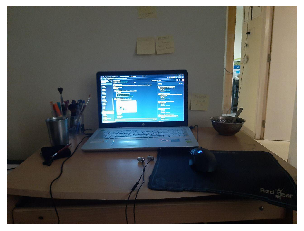

Greedy Search:  a laptop computer sitting on top of a wooden desk
Beam Search (k=3):  a laptop computer sitting on top of a wooden desk
Beam Search (k=5):  a laptop computer sitting on top of a wooden desk next to a window
Beam Search (k=7):  a laptop computer sitting on top of a wooden desk next to a window


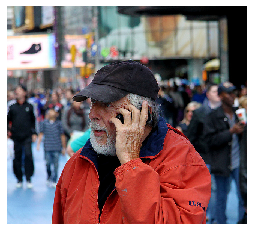

Greedy Search:  a man wearing a hat and talking on a cell phone
Beam Search (k=3):  a man talking on a cell phone in front of a crowd of people
Beam Search (k=5):  a man talking on a cell phone in front of a crowd of people
Beam Search (k=7):  a man talking on a cell phone in front of a crowd of people


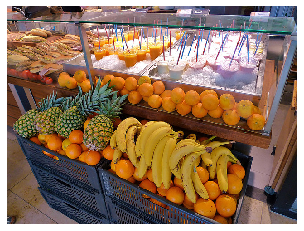

Greedy Search:  a man standing next to a fruit stand with a bunch of bananas
Beam Search (k=3):  a bunch of fruits that are on display
Beam Search (k=5):  a bunch of fruits that are sitting on a cart
Beam Search (k=7):  a variety of fruits and vegetables on display in a market


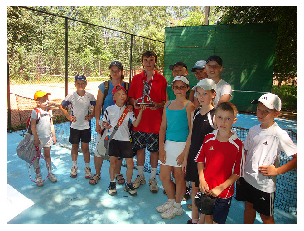

Greedy Search:  a group of people standing around a tennis court
Beam Search (k=3):  a group of people standing on a tennis court holding racquets
Beam Search (k=5):  a group of people on a tennis court playing tennis
Beam Search (k=7):  a group of people on a tennis court playing tennis


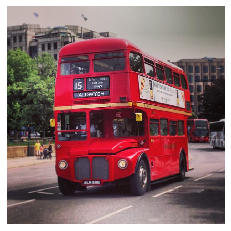

Greedy Search:  a double decker bus is driving down the street
Beam Search (k=3):  a red double decker bus driving down a street
Beam Search (k=5):  a red double decker bus driving down a street next to a bus
Beam Search (k=7):  a red double decker bus driving down a street next to a bus


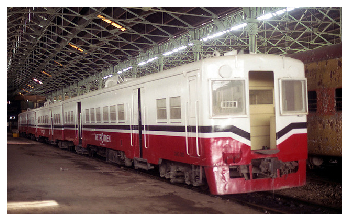

Greedy Search:  a train is on the tracks near a platform
Beam Search (k=3):  a train traveling down train tracks next to a train station
Beam Search (k=5):  there is a train that is stopped at the station
Beam Search (k=7):  there is a train that is going down the track
Captioned 17 images in 128.66s


In [11]:
# pic = list(encoding_test.keys())[z]
# imgPath = "./coco/train2014/COCO_train2014_000000000030.jpg"
images = ['./coco/COCO_val2014_000000000133.jpg',
          './coco/COCO_val2014_000000000042.jpg',
          './coco/COCO_val2014_000000000073.jpg',
          './coco/COCO_val2014_000000000136.jpg',
          './coco/COCO_val2014_000000000139.jpg',
          './coco/COCO_val2014_000000000143.jpg',
          './coco/COCO_val2014_000000000164.jpg',
          './coco/COCO_val2014_000000000192.jpg',
          './coco/COCO_val2014_000000000196.jpg',
          './coco/COCO_val2014_000000000208.jpg',
          './coco/COCO_val2014_000000000241.jpg',
          './coco/photo_2020-03-04_18-06-03.jpg',
         './coco/COCO_val2014_000000000395.jpg',
         './coco/COCO_val2014_000000000715.jpg', './coco/COCO_val2014_000000001000.jpg', './coco/COCO_val2014_000000001584.jpg',
         './coco/COCO_val2014_000000003342.jpg']

start = time.time()
for imgPath in images:
    image = getFeatureVector(imgPath)
    image = image.reshape((1,2048))
    x=plt.imread(imgPath)
    plt.axis('off')
    plt.imshow(x)
    plt.show()
    print("Greedy Search: ", greedySearch(image))
    print("Beam Search (k=3): ", beam_search_predictions(image))
    print("Beam Search (k=5): ", beam_search_predictions(image, beam_index=5))
    print("Beam Search (k=7): ", beam_search_predictions(image, beam_index=7))
print("Captioned {} images in {:.2f}s".format(len(images), time.time() - start))